In [188]:
pip install dill

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\ASUS\python work\statsm\Scripts\python.exe -m pip install --upgrade pip


In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
import dill
from statsmodels.tsa.seasonal import seasonal_decompose

In [82]:
# Load data
data = pd.read_csv(r'C:\Users\ASUS\Downloads\Walmart DataSet.csv') 

In [268]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [10]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [178]:
# Try to convert date to "dd mm yyyy" format, handling different formats
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data.set_index('Date', inplace=True)

<b> a. </b> Weekly Sales vs Unemployment Rate

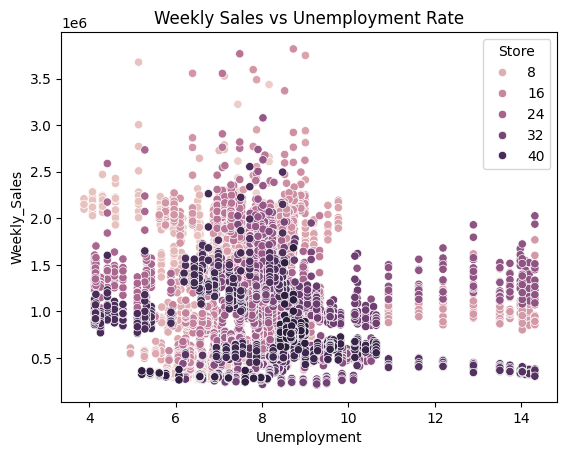

In [13]:
# EDA and Statistical Analysis

# a. Weekly Sales vs Unemployment Rate
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=data, hue = 'Store')
plt.title('Weekly Sales vs Unemployment Rate')
plt.show()

In [14]:
grouped_data = data.groupby('Store').agg({'Weekly_Sales': 'mean', 'Unemployment' : 'mean'})
avg_weekly_sales = data.Weekly_Sales.mean()
print("Average weekly sales :" , avg_weekly_sales)
high_unemployment_stores = grouped_data.sort_values(by = 'Unemployment', ascending = False).head(5)
high_unemployment_stores

Average weekly sales : 1046964.8775617715


,Weekly_Sales,Unemployment
Store,,
12,1.009002e+06,13.116483
38,3.857317e+05,13.116483
28,1.323522e+06,13.116483
43,6.333247e+05,9.934804
34,9.667816e+05,9.934804


In [15]:
high_unemployment_stores[high_unemployment_stores['Weekly_Sales'] <= avg_weekly_sales]

,Weekly_Sales,Unemployment
Store,,
12,1.009002e+06,13.116483
38,3.857317e+05,13.116483
43,6.333247e+05,9.934804
34,9.667816e+05,9.934804


<b> b. </b> Weekly Sales Seasonal Trend

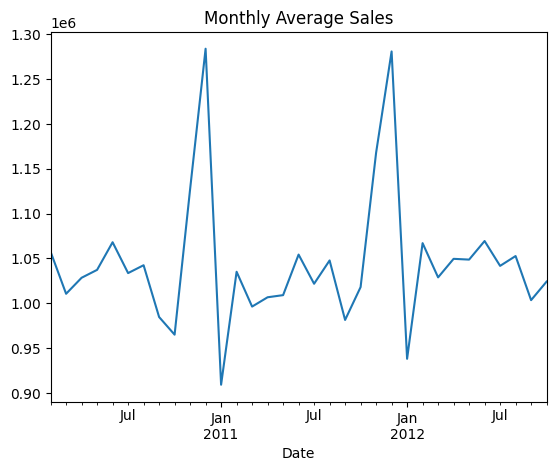

In [17]:
data['Weekly_Sales'].resample('ME').mean().plot(title='Monthly Average Sales')
plt.show()

<b>c. </b> Weekly Sales vs Temperature

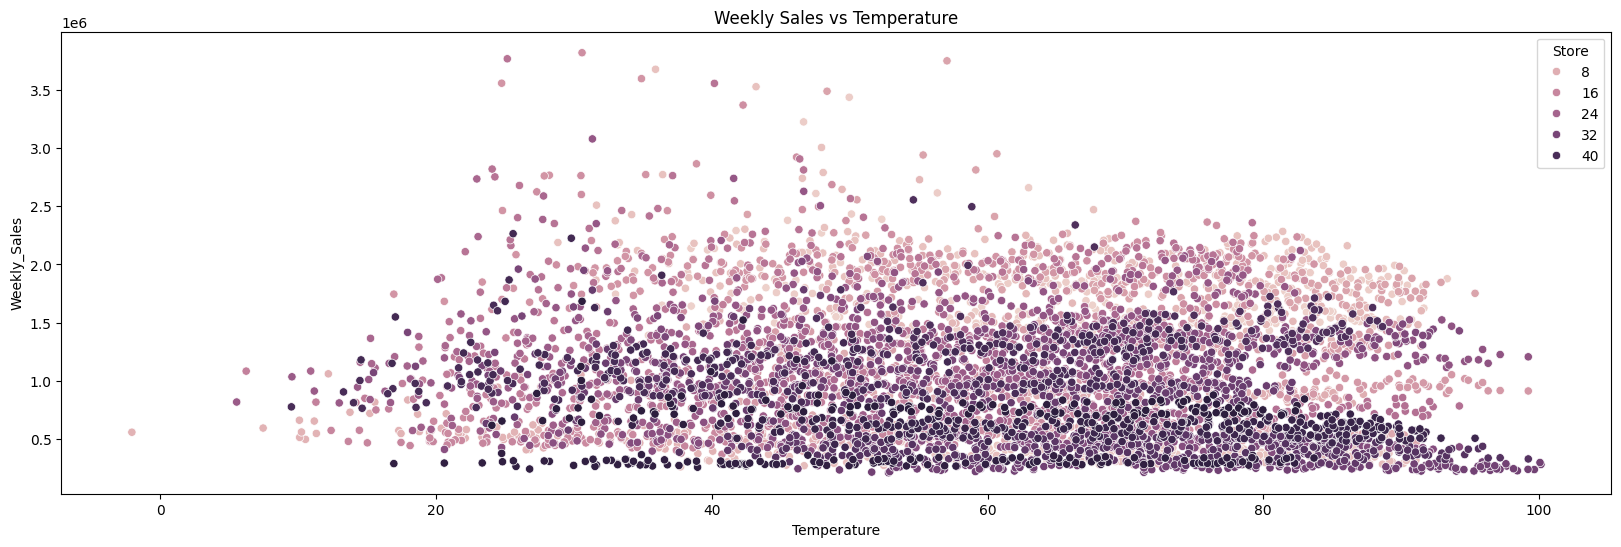

In [19]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data, hue = 'Store')
plt.title('Weekly Sales vs Temperature')
plt.show()


<b> d. </b> Weekly Sales vs Consumer Price Index (CPI)

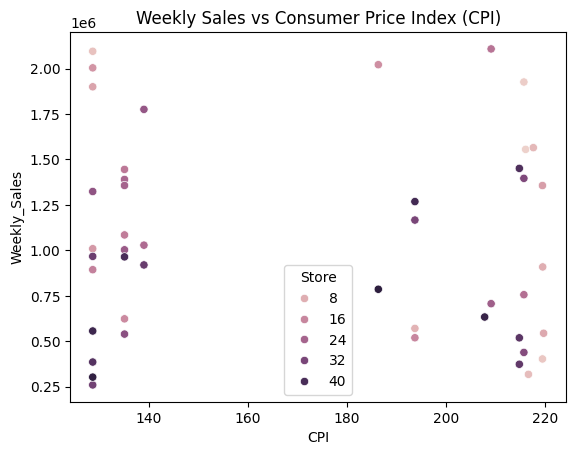

In [21]:
sns.scatterplot(x='CPI', y='Weekly_Sales', data=data.groupby('Store').agg({'Weekly_Sales': 'mean', 'CPI' : 'mean'}), hue = 'Store')
plt.title('Weekly Sales vs Consumer Price Index (CPI)')
plt.show()

<b> e. </b> Top performing stores

In [23]:
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
print('Top Performing Stores:')
print(top_stores)


Top Performing Stores:
Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
Name: Weekly_Sales, dtype: float64


<b> f. </b> Worst performing store

In [25]:
# f. Worst performing store
worst_store = data.groupby('Store')['Weekly_Sales'].sum().idxmin()
print()
print('Worst Performing Store:', worst_store)


Worst Performing Store: 33


In [28]:
def adfuller_test(sales_amount):
    result = adfuller(sales_amount)
    labels = ['ADF Test-statistic', 'p-value', 'Lags Used', 'Observations Used']
    #for label, value in zip(labels, result):
        #print(label, ":", value)
    if result[1] < 0.05:
        return("Stationary")
    else:
        return("Non-stationary.")

In [29]:
grouped_data = data.groupby(['Store','Date']).agg({'Weekly_Sales': 'mean'})

In [30]:
sales1 = data[data['Store'] == 1][['Weekly_Sales']]

In [31]:
sales1

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


<Figure size 1200x500 with 0 Axes>

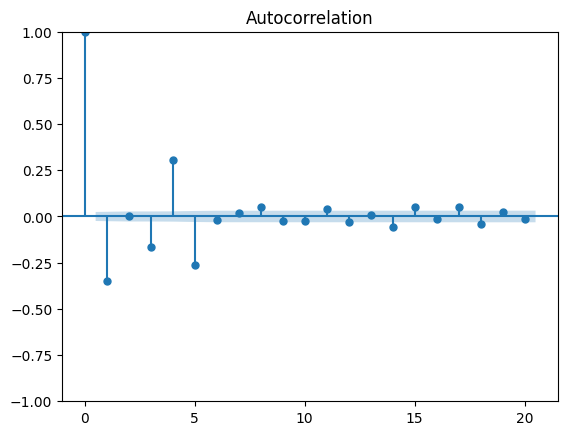

<Figure size 1200x500 with 0 Axes>

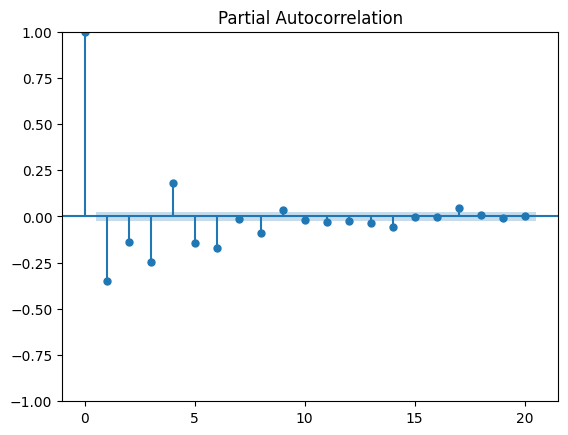

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(data['Weekly_Sales'].diff().dropna(), lags=20)  # ACF for q
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(data['Weekly_Sales'].diff().dropna(), lags=20)  # PACF for p
plt.show()

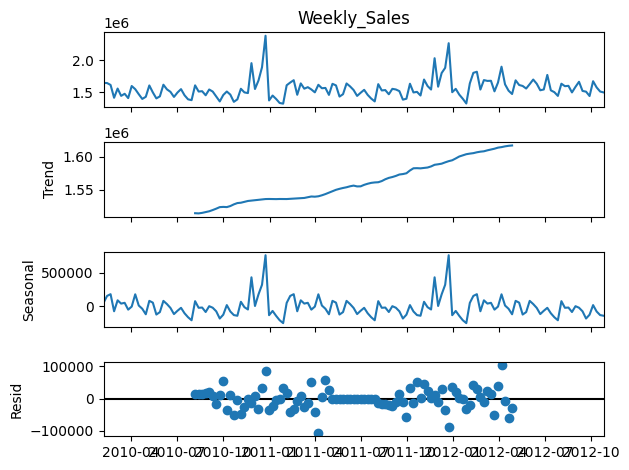

In [284]:
decomposed = seasonal_decompose(sales1['Weekly_Sales'], period=52)  # Adjust `period`
decomposed.plot()
plt.show()

In [33]:
import itertools

In [56]:
p = range(0, 8)
q = range(0, 8)
d = range(0, 2)

In [62]:
pdq_combination = list(itertools.product(p,d,q))

In [64]:
len(pdq_combination)

128

In [102]:
143 * 0.8

114.4

In [148]:
min_pdq_values = []

In [154]:
len(min_pdq_values)

45

In [138]:
import warnings

In [182]:
warnings.filterwarnings('ignore')
for i in range(1, 46):
    sales = data[data['Store'] == i][['Weekly_Sales']]
    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        train = sales[:114]
        test = sales[114:]
        min_value = 1000000
        print(len(sales))
        minp, minq, mind = 0, 0, 0
        for p, d, q in pdq_combination:
            model = ARIMA(train, order = (p, d, q))
            result = model.fit()
            prediction = result.predict(start = 114, end = len(sales) - 1)
            rmse = np.sqrt(mean_squared_error(test, prediction))
            if (rmse < min_value):
                minp, minq, mind = p, q, d
                min_value = rmse
    else:
        print("Unable to process : Store number ", i)
    print("(", minp, ",", mind, ",", minq, ") :", min_value)
    min_pdq_values.append((minp, mind, minq))

143
( 2 , 0 , 7 ) : 78194.83655472752
143
( 4 , 1 , 2 ) : 78247.31595869699
143
( 4 , 0 , 1 ) : 19106.98276410227
143
( 3 , 0 , 2 ) : 73490.79456269418
143
( 4 , 0 , 1 ) : 15419.992375119695
143
( 0 , 0 , 1 ) : 107416.11320970129
143
( 6 , 1 , 7 ) : 87157.70583759774
143
( 0 , 0 , 0 ) : 30617.587530372522
143
( 4 , 0 , 0 ) : 25494.51503069089
143
( 4 , 1 , 2 ) : 145293.829142581
143
( 2 , 0 , 2 ) : 69506.79399422853
143
( 5 , 1 , 6 ) : 50919.06974636004
143
( 4 , 1 , 2 ) : 80744.87483326376
Unable to process : Store number  14
( 4 , 1 , 2 ) : 80744.87483326376
143
( 0 , 1 , 2 ) : 46329.363457167776
143
( 6 , 1 , 6 ) : 52665.31080966926
143
( 1 , 1 , 0 ) : 81057.68392127783
143
( 4 , 1 , 3 ) : 65805.78768242087
143
( 0 , 1 , 2 ) : 94700.77197377227
143
( 0 , 0 , 0 ) : 110125.52774772324
143
( 0 , 1 , 1 ) : 67991.37263815729
143
( 0 , 0 , 0 ) : 61053.169872860504
143
( 0 , 0 , 0 ) : 116492.89249859368
143
( 3 , 1 , 0 ) : 97104.87402322766
143
( 0 , 0 , 0 ) : 33481.13047445728
143
( 4 , 1

In [294]:
min_pdqs_values = []

[(4, 1, 2, 52), (4, 1, 2, 52), (4, 1, 2, 52), (4, 1, 2, 52)]

In [292]:
warnings.filterwarnings('ignore')
for i in range(1, 5):
    sales = data[data['Store'] == i][['Weekly_Sales']]
    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        train = sales[:114]
        test = sales[114:]
        min_value = 1000000
        print(len(sales))
        minP, minD, minQ = 0, 0, 0
        p, d, q = min_pdq_values[i]
        for P, D, Q in pdq_combination:
            model = SARIMAX(train, order = (p, d, q), seasonal = (P, D, Q, 52))
            result = model.fit()
            prediction = result.predict(start = 114, end = len(sales) - 1)
            rmse = np.sqrt(mean_squared_error(test, prediction))
            if (rmse < min_value):
                minP, minQ, minD = P, Q, D
                min_value = rmse
    else:
        print("Unable to process : Store number ", i)
    print("(", minP, ",", minD, ",", minQ, ") :", min_value)
    min_pdqs_values.append((minp, mind, minq, 52))

143
( 0 , 0 , 0 ) : 123076.96132789165
143
( 0 , 0 , 0 ) : 85961.34558022299
143
( 0 , 0 , 0 ) : 39710.006669165276
143
( 0 , 0 , 0 ) : 96515.25515929332


In [334]:
dill.dump_session("min_pdq_values.db")

In [ ]:
dill.load_session("min_pdq_values.db")

            Weekly_Sales
Date                    
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
2 0 7


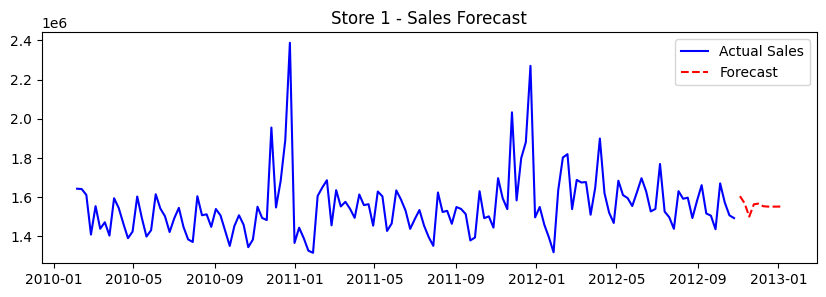

            Weekly_Sales
Date                    
2010-02-05    2136989.46
2010-02-12    2137809.50
2010-02-19    2124451.54
2010-02-26    1865097.27
2010-03-05    1991013.13
4 1 2


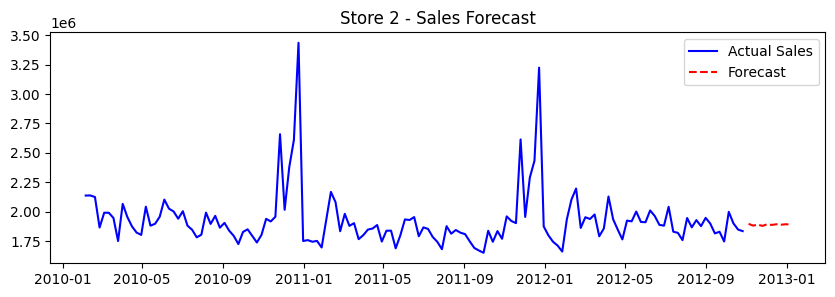

            Weekly_Sales
Date                    
2010-02-05     461622.22
2010-02-12     420728.96
2010-02-19     421642.19
2010-02-26     407204.86
2010-03-05     415202.04
4 0 1


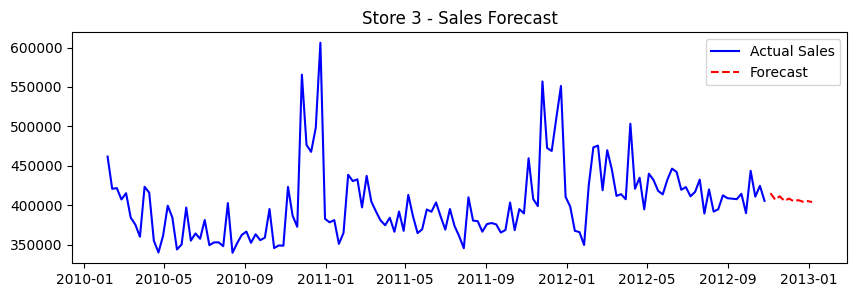

            Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
3 0 2


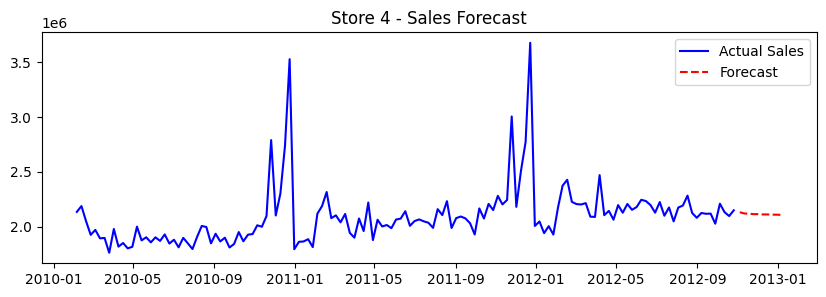

In [310]:
warnings.filterwarnings('ignore')
for i in range(1, 5):
    sales = data[data['Store'] == i][['Weekly_Sales']]
    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        print(sales.head())
        p, d, q = min_pdq_values[i - 1]
        print (p, d, q)
        model = ARIMA(sales, order = (p, d, q))
        result = model.fit()
        
        # Generate future dates for forecasting
        future_dates = pd.date_range(start=sales.index[-1], periods=11, freq='W')[1:]
        
        # Forecast values for the next 10 weeks
        forecast_values = result.forecast(10)
        
        # Create a new DataFrame for the forecast
        forecast_df = pd.DataFrame({'Weekly_Sales': forecast_values}, index=future_dates)
        
        # Plot original data
        plt.figure(figsize=(10, 3))
        plt.plot(sales.index, sales['Weekly_Sales'], label='Actual Sales', color='blue')
        plt.plot(future_dates, forecast_values, label='Forecast', color='red', linestyle='dashed')
        
        plt.title(f'Store {i} - Sales Forecast')
        plt.legend()
        plt.show()
    else:
        print("Unable to process : Store number ", i)

            Weekly_Sales
Date                    
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
2 0 7


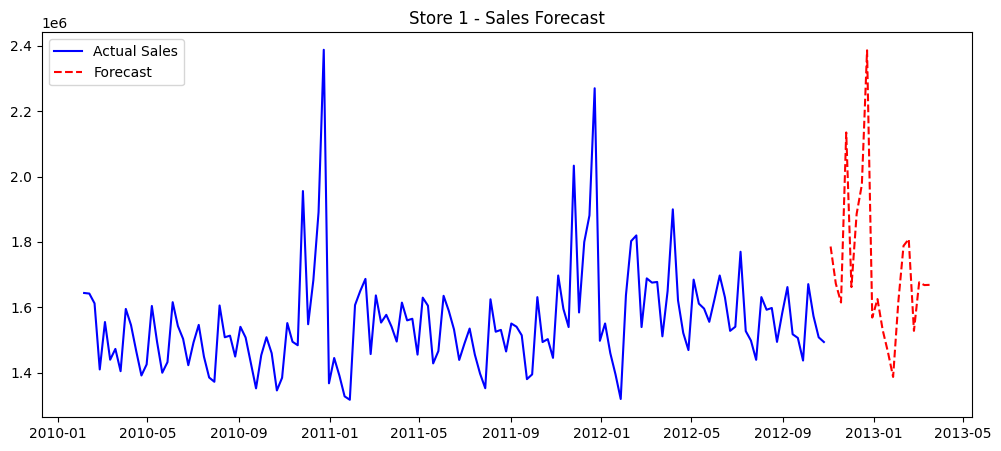

            Weekly_Sales
Date                    
2010-02-05    2136989.46
2010-02-12    2137809.50
2010-02-19    2124451.54
2010-02-26    1865097.27
2010-03-05    1991013.13
4 1 2


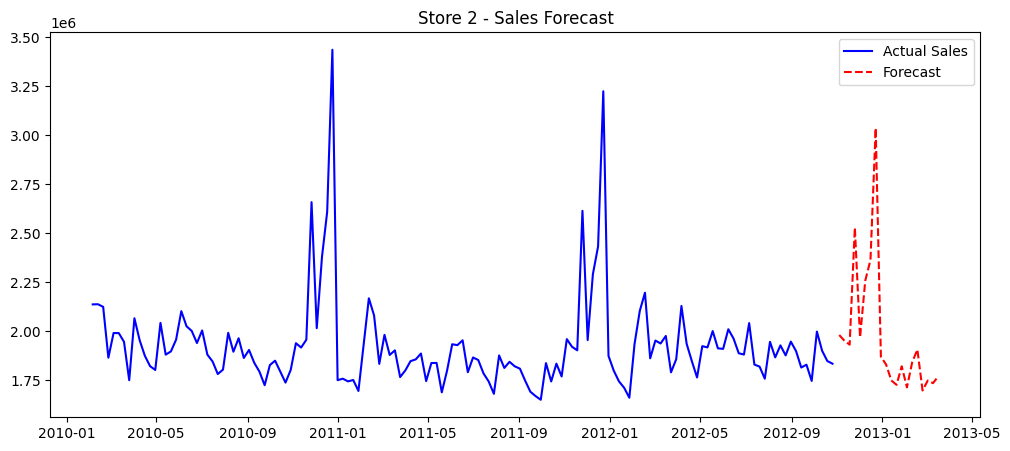

            Weekly_Sales
Date                    
2010-02-05     461622.22
2010-02-12     420728.96
2010-02-19     421642.19
2010-02-26     407204.86
2010-03-05     415202.04
4 0 1


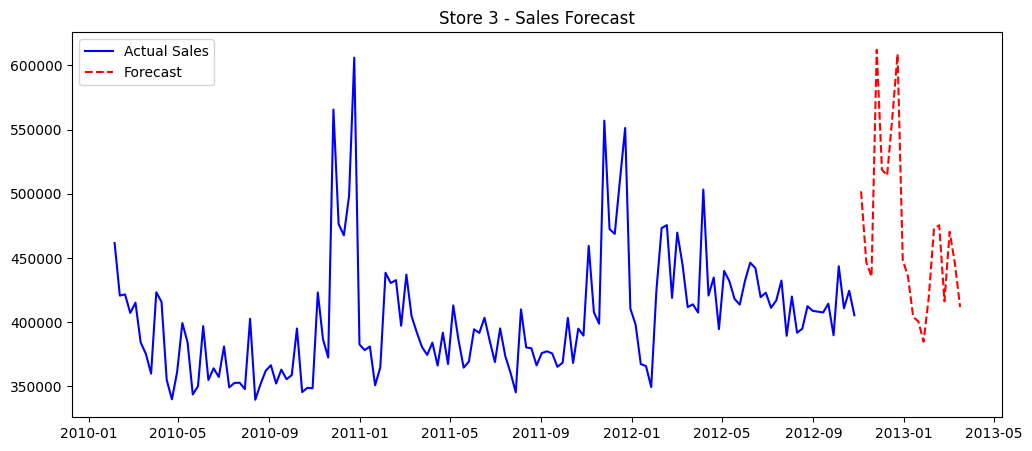

            Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
3 0 2


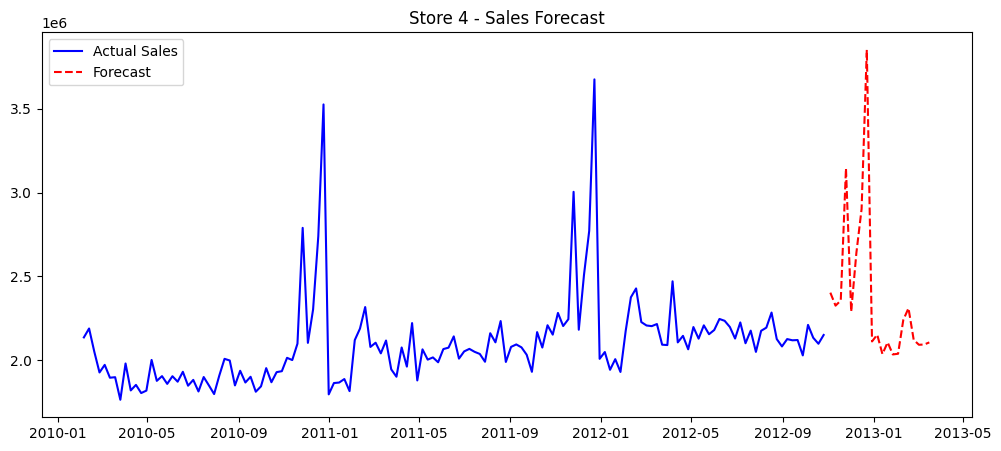

            Weekly_Sales
Date                    
2010-02-05     317173.10
2010-02-12     311825.70
2010-02-19     303447.57
2010-02-26     270281.63
2010-03-05     288855.71
4 0 1


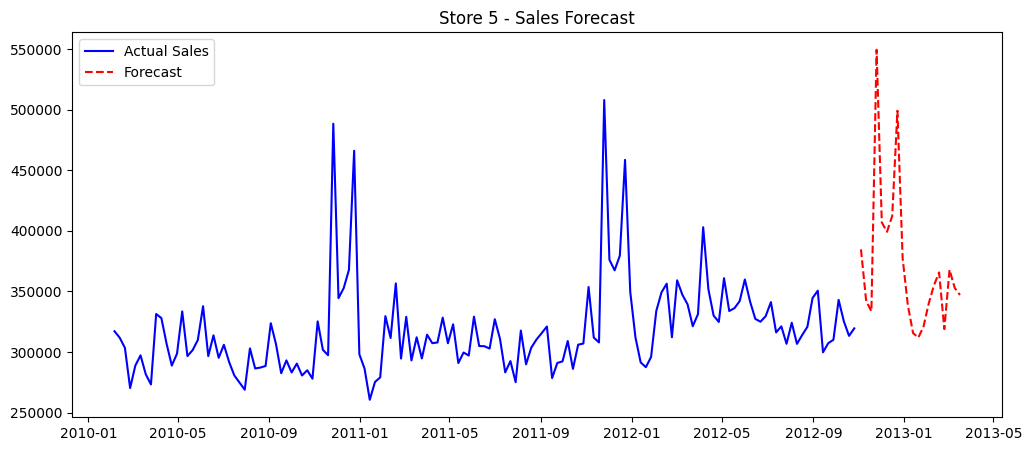

            Weekly_Sales
Date                    
2010-02-05    1652635.10
2010-02-12    1606283.86
2010-02-19    1567138.07
2010-02-26    1432953.21
2010-03-05    1601348.82
0 0 1


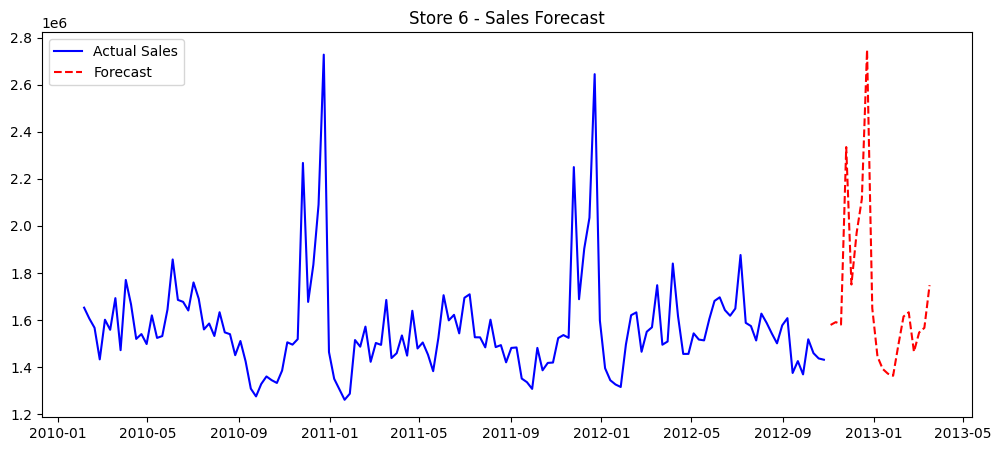

            Weekly_Sales
Date                    
2010-02-05     496725.44
2010-02-12     524104.92
2010-02-19     506760.54
2010-02-26     496083.24
2010-03-05     491419.55
6 1 7


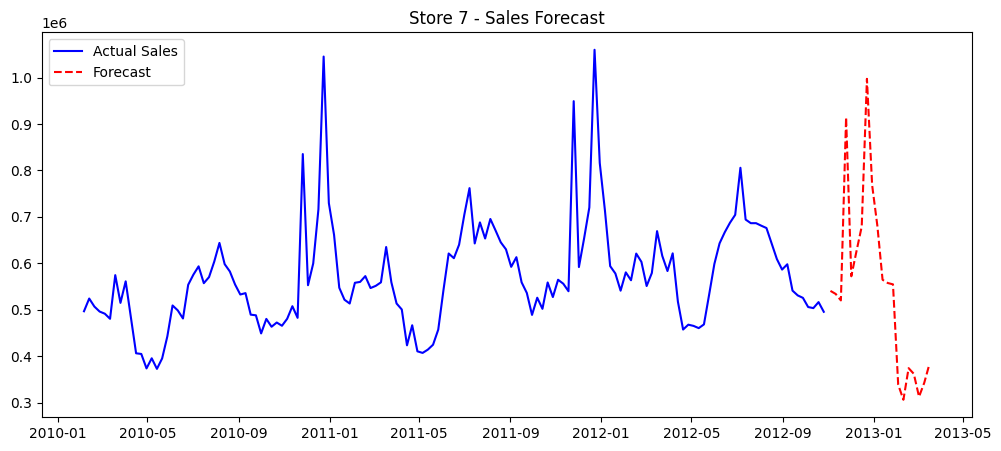

            Weekly_Sales
Date                    
2010-02-05    1004137.09
2010-02-12     994801.40
2010-02-19     963960.37
2010-02-26     847592.11
2010-03-05     881503.95
0 0 0


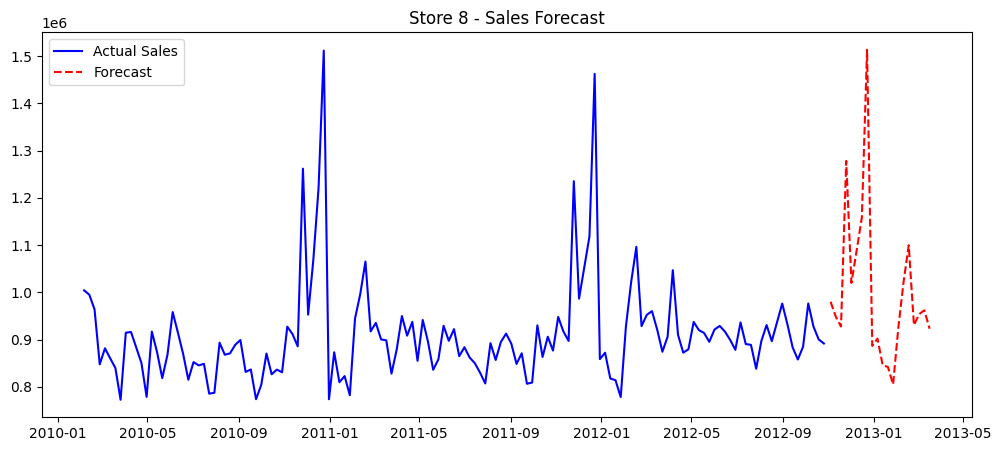

            Weekly_Sales
Date                    
2010-02-05     549505.55
2010-02-12     552677.48
2010-02-19     511327.90
2010-02-26     473773.27
2010-03-05     507297.88
4 0 0


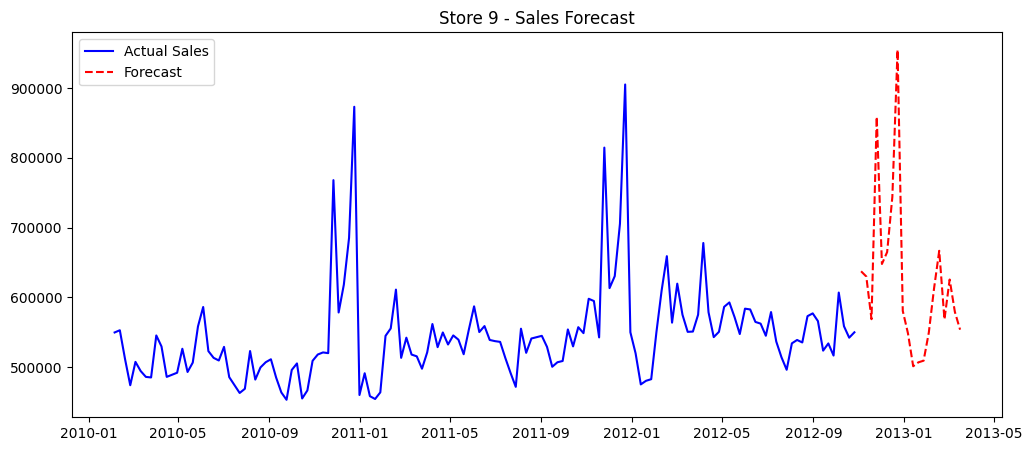

            Weekly_Sales
Date                    
2010-02-05    2193048.75
2010-02-12    2176028.52
2010-02-19    2113432.58
2010-02-26    2006774.96
2010-03-05    1987090.09
4 1 2


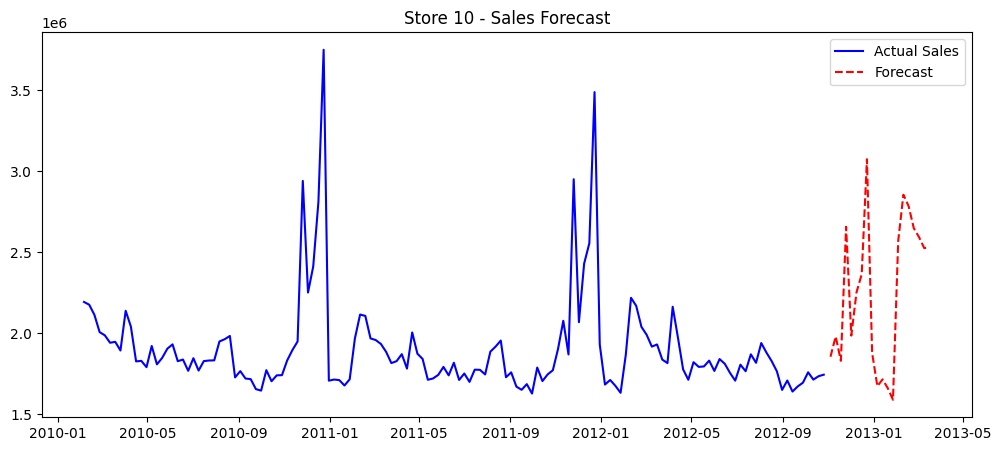

            Weekly_Sales
Date                    
2010-02-05    1528008.64
2010-02-12    1574684.08
2010-02-19    1503298.70
2010-02-26    1336404.65
2010-03-05    1426622.65
2 0 2


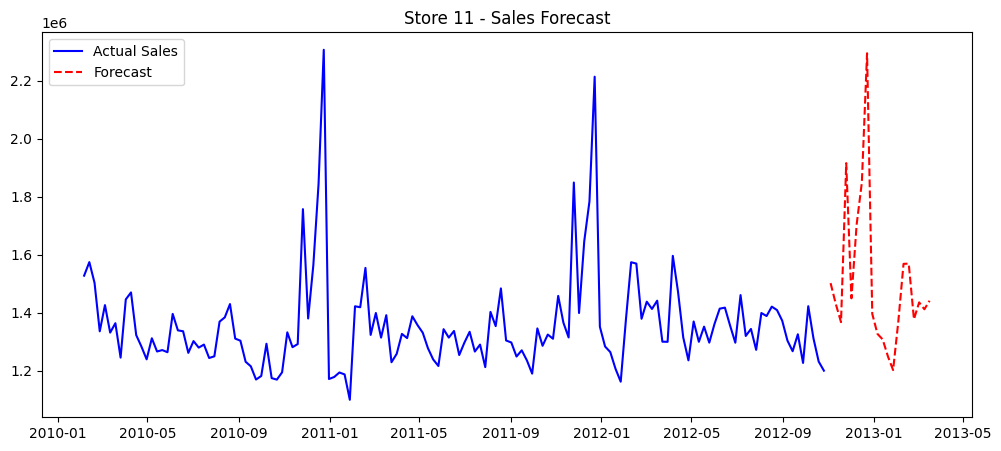

            Weekly_Sales
Date                    
2010-02-05    1100046.37
2010-02-12    1117863.33
2010-02-19    1095421.65
2010-02-26    1048617.17
2010-03-05    1077018.27
5 1 6


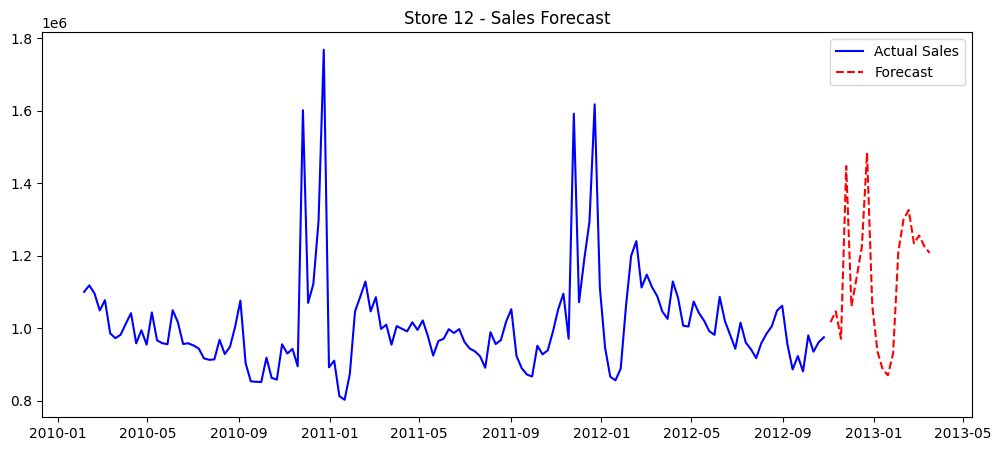

            Weekly_Sales
Date                    
2010-02-05    1967220.53
2010-02-12    2030933.46
2010-02-19    1970274.64
2010-02-26    1817850.32
2010-03-05    1939980.43
4 1 2


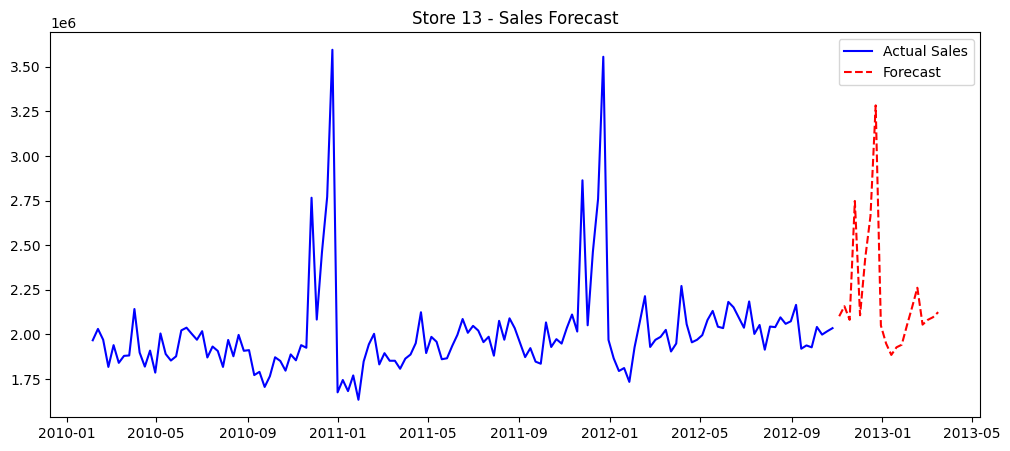

Unable to process: Store number 14
            Weekly_Sales
Date                    
2010-02-05     652122.44
2010-02-12     682447.10
2010-02-19     660838.75
2010-02-26     564883.20
2010-03-05     605325.43
0 1 2


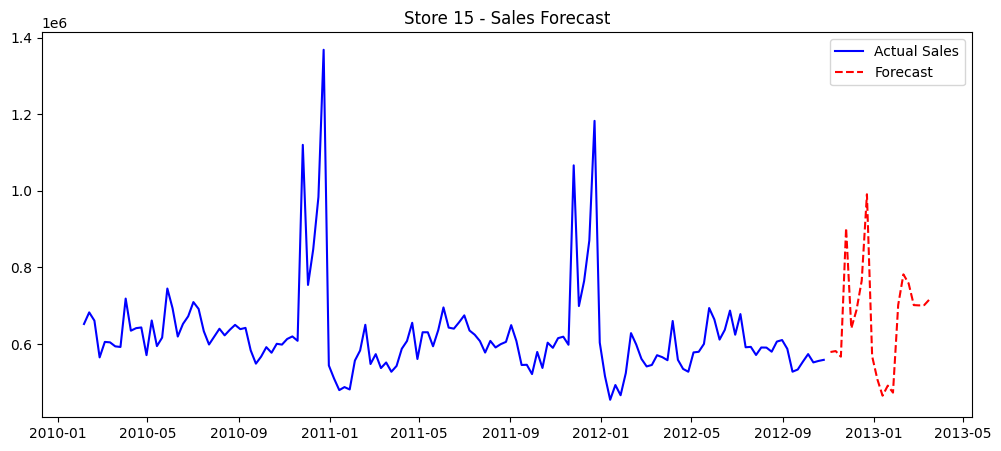

            Weekly_Sales
Date                    
2010-02-05     477409.30
2010-02-12     472044.28
2010-02-19     469868.70
2010-02-26     443242.17
2010-03-05     444181.85
6 1 6


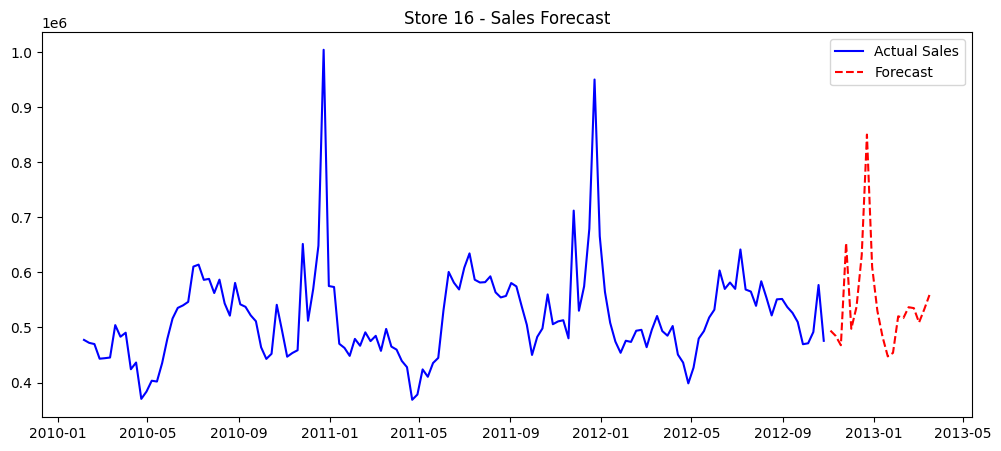

            Weekly_Sales
Date                    
2010-02-05     789036.02
2010-02-12     841951.91
2010-02-19     800714.00
2010-02-26     749549.55
2010-03-05     783300.05
1 1 0


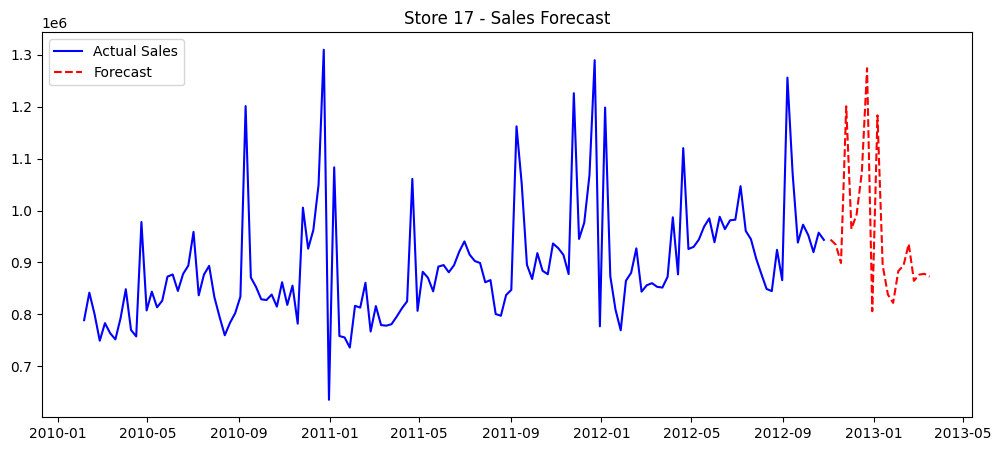

            Weekly_Sales
Date                    
2010-02-05    1205307.50
2010-02-12    1187880.70
2010-02-19    1150663.42
2010-02-26    1068157.45
2010-03-05    1179738.50
4 1 3


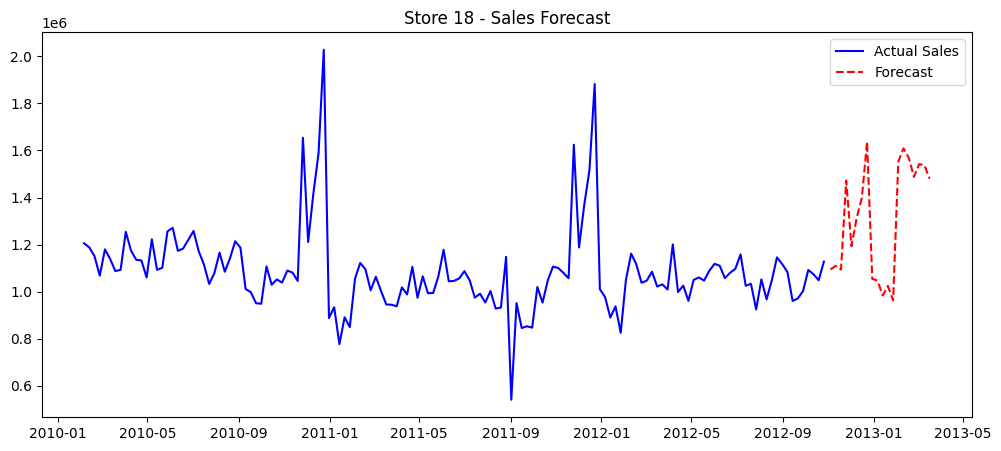

            Weekly_Sales
Date                    
2010-02-05    1507637.17
2010-02-12    1536549.95
2010-02-19    1515976.11
2010-02-26    1373270.06
2010-03-05    1495844.57
0 1 2


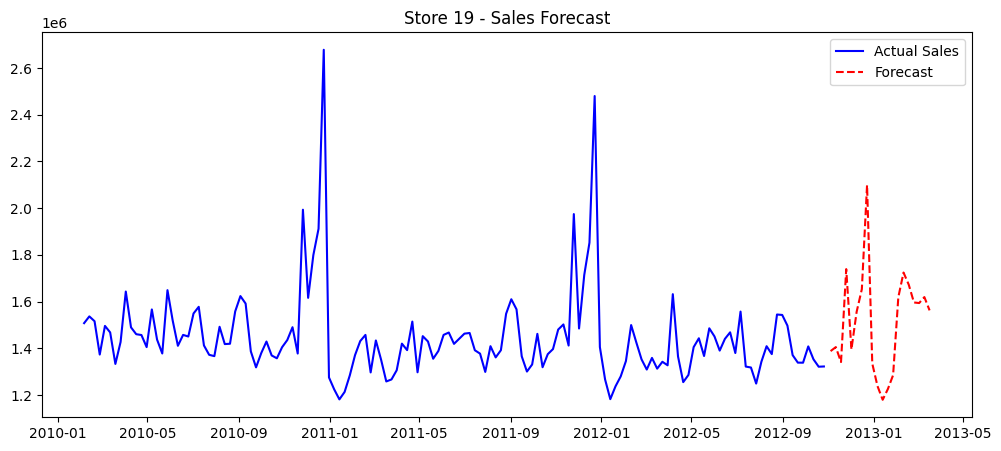

            Weekly_Sales
Date                    
2010-02-05    2401395.47
2010-02-12    2109107.90
2010-02-19    2161549.76
2010-02-26    1898193.95
2010-03-05    2119213.72
0 0 0


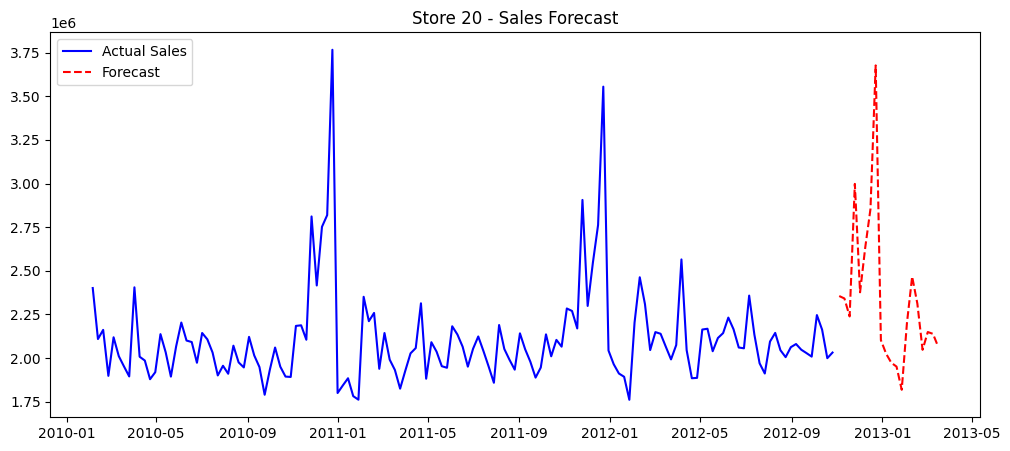

            Weekly_Sales
Date                    
2010-02-05     798593.88
2010-02-12     809321.44
2010-02-19     867283.25
2010-02-26     749597.24
2010-03-05     747444.32
0 1 1


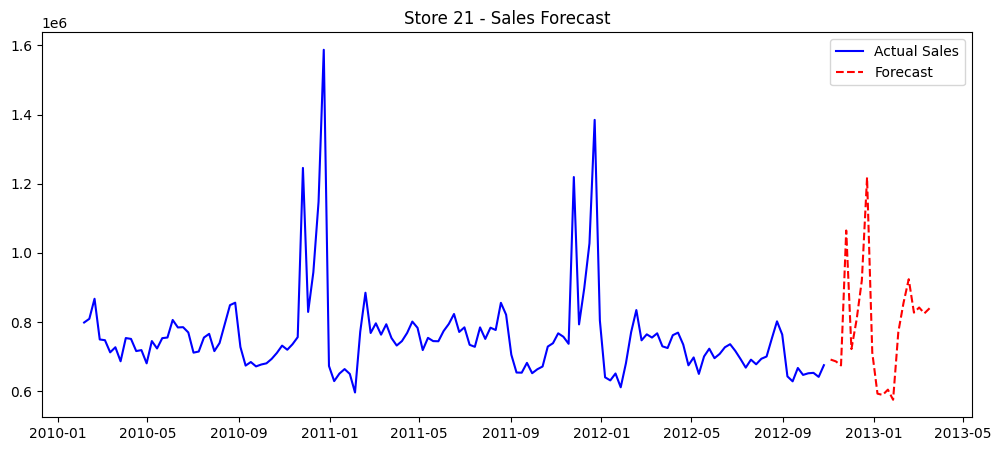

            Weekly_Sales
Date                    
2010-02-05    1033017.37
2010-02-12    1022571.25
2010-02-19     988467.61
2010-02-26     899761.48
2010-03-05    1009201.24
0 0 0


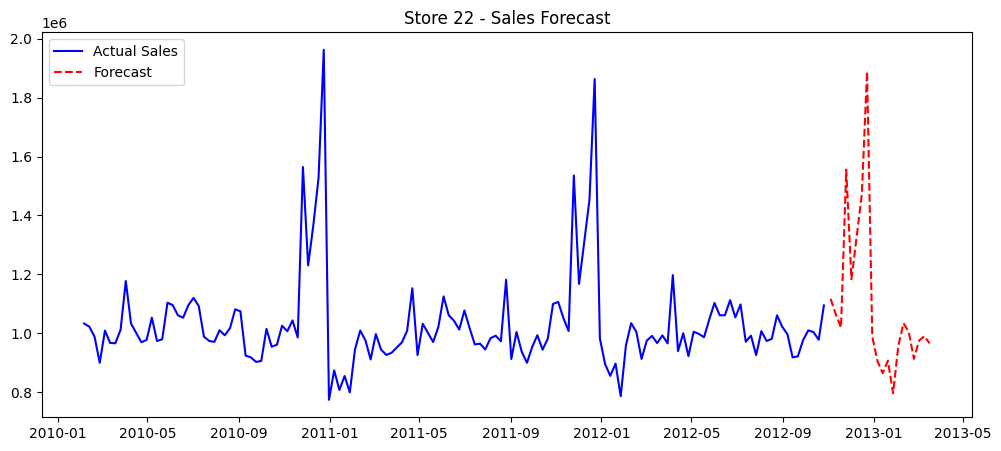

            Weekly_Sales
Date                    
2010-02-05    1364721.58
2010-02-12    1380892.08
2010-02-19    1319588.04
2010-02-26    1198709.65
2010-03-05    1311175.93
0 0 0


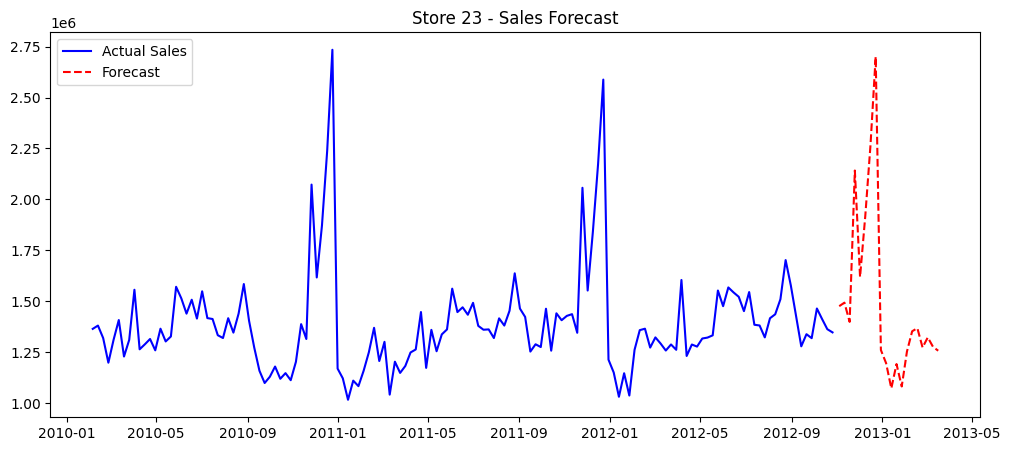

            Weekly_Sales
Date                    
2010-02-05    1388725.63
2010-02-12    1414107.10
2010-02-19    1385362.49
2010-02-26    1158722.74
2010-03-05    1412387.37
3 1 0


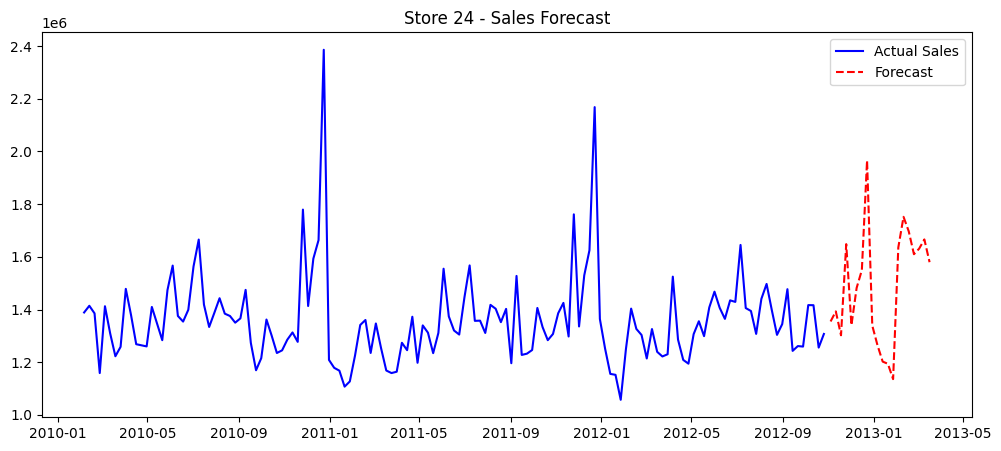

            Weekly_Sales
Date                    
2010-02-05     677231.63
2010-02-12     583364.02
2010-02-19     676260.67
2010-02-26     628516.57
2010-03-05     665750.06
0 0 0


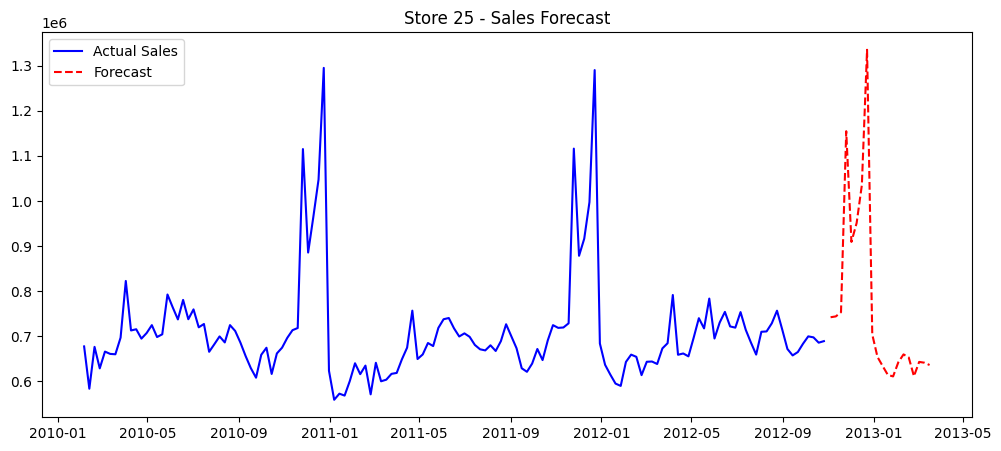

            Weekly_Sales
Date                    
2010-02-05    1034119.21
2010-02-12    1015684.09
2010-02-19     999348.55
2010-02-26     855385.01
2010-03-05    1005669.58
4 1 0


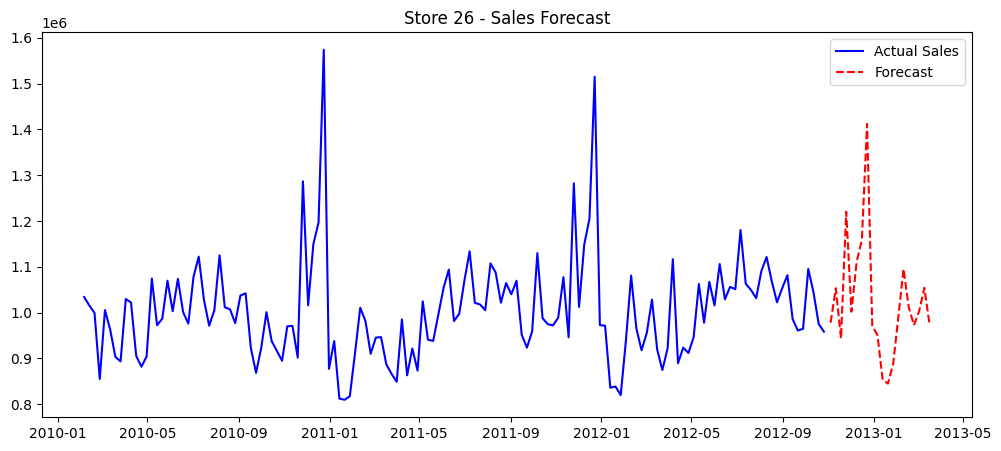

            Weekly_Sales
Date                    
2010-02-05    1874289.79
2010-02-12    1745362.72
2010-02-19    1945070.33
2010-02-26    1390934.27
2010-03-05    1313729.72
2 1 3


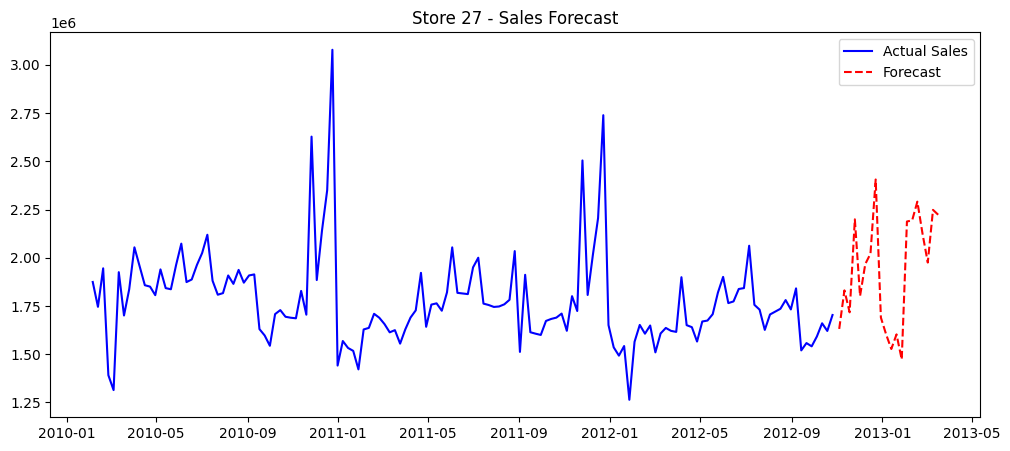

            Weekly_Sales
Date                    
2010-02-05    1672352.29
2010-02-12    1558968.49
2010-02-19    1491300.42
2010-02-26    1542173.33
2010-03-05    1608435.45
7 0 7


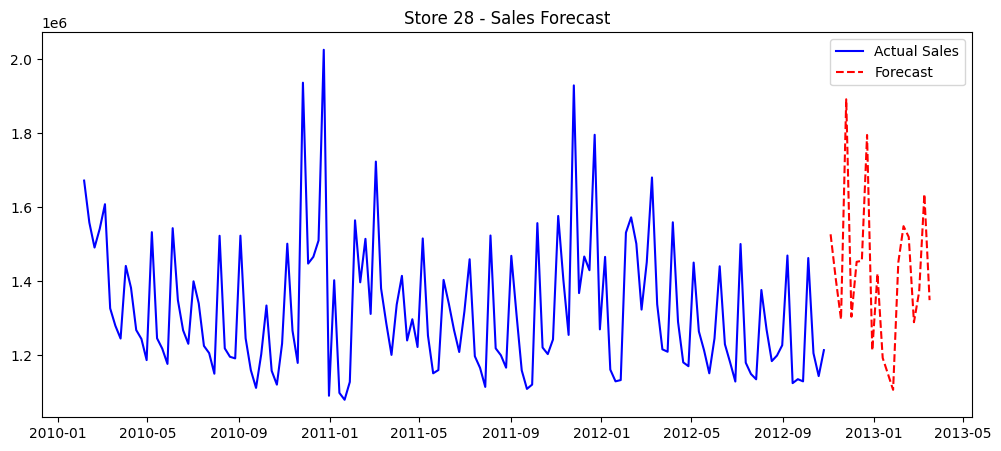

            Weekly_Sales
Date                    
2010-02-05     538634.46
2010-02-12     529672.95
2010-02-19     542399.07
2010-02-26     488417.61
2010-03-05     535087.91
2 1 1


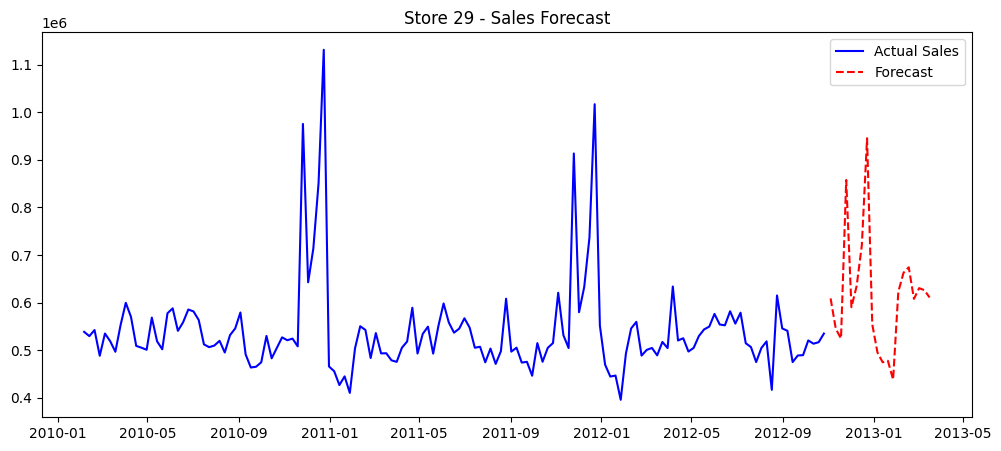

Unable to process: Store number 30
            Weekly_Sales
Date                    
2010-02-05    1469252.05
2010-02-12    1543947.23
2010-02-19    1473386.75
2010-02-26    1344354.41
2010-03-05    1384870.51
6 0 6


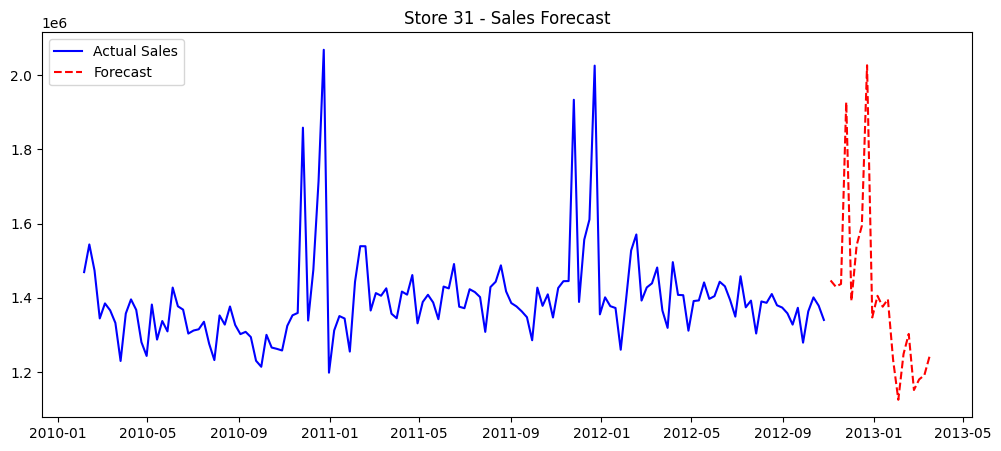

            Weekly_Sales
Date                    
2010-02-05    1087616.19
2010-02-12    1123566.12
2010-02-19    1082559.06
2010-02-26    1053247.10
2010-03-05    1066566.74
2 1 4


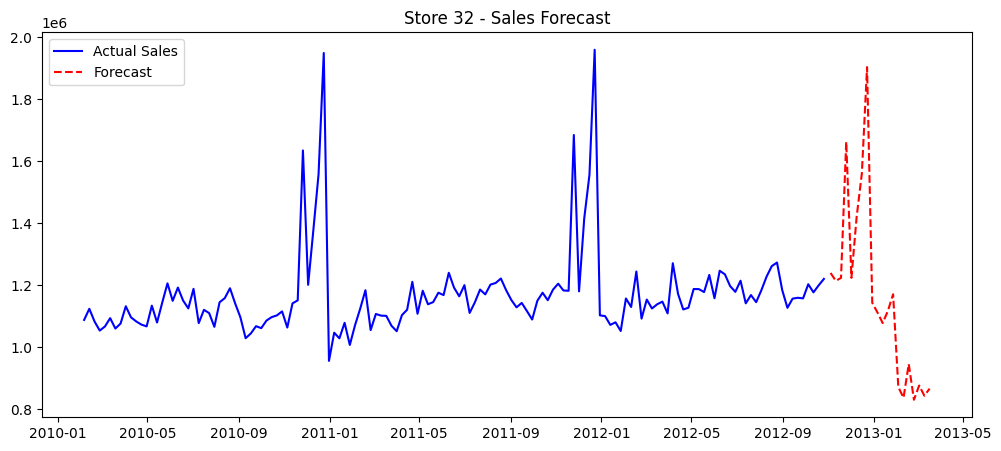

            Weekly_Sales
Date                    
2010-02-05     274593.43
2010-02-12     294882.83
2010-02-19     296850.83
2010-02-26     284052.77
2010-03-05     291484.89
6 0 6


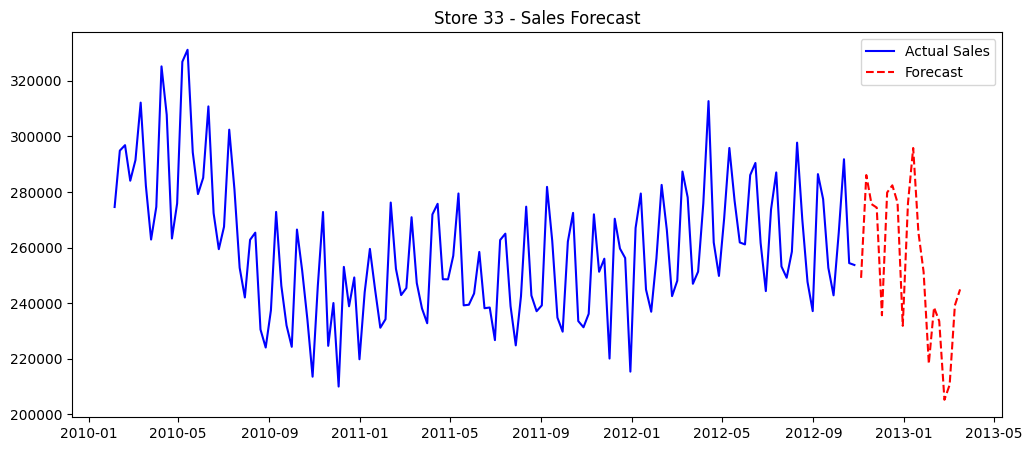

            Weekly_Sales
Date                    
2010-02-05     956228.96
2010-02-12     994610.99
2010-02-19     983963.07
2010-02-26     905756.13
2010-03-05     918295.79
4 0 0


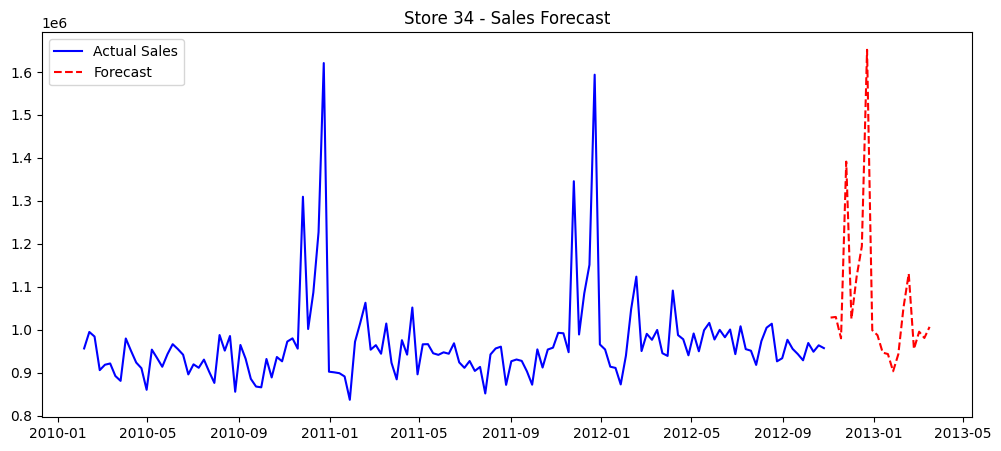

            Weekly_Sales
Date                    
2010-02-05    1230613.50
2010-02-12    1168815.31
2010-02-19    1270658.64
2010-02-26    1020651.74
2010-03-05    1162610.27
4 1 4


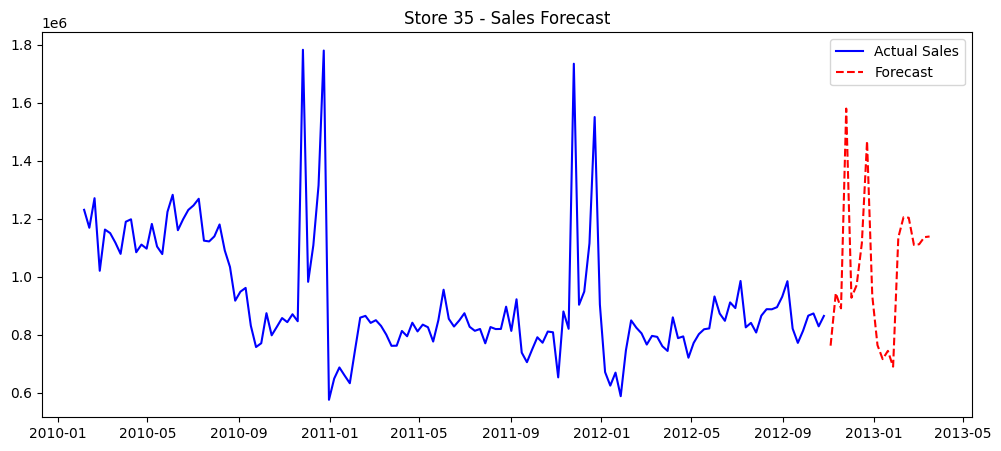

Unable to process: Store number 36
            Weekly_Sales
Date                    
2010-02-05     536006.73
2010-02-12     529852.70
2010-02-19     510382.50
2010-02-26     513615.82
2010-03-05     519255.68
5 0 1


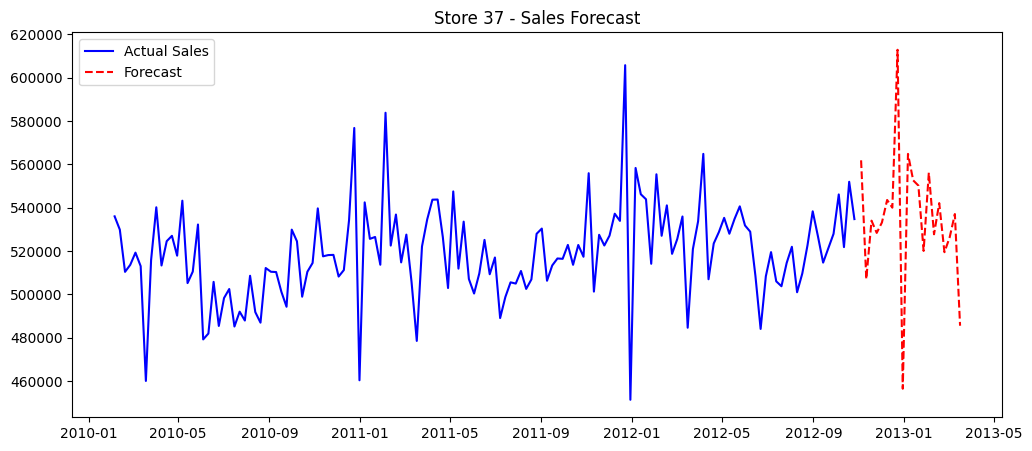

Unable to process: Store number 38
            Weekly_Sales
Date                    
2010-02-05    1230596.80
2010-02-12    1266229.07
2010-02-19    1230591.97
2010-02-26    1168582.02
2010-03-05    1266254.21
0 1 3


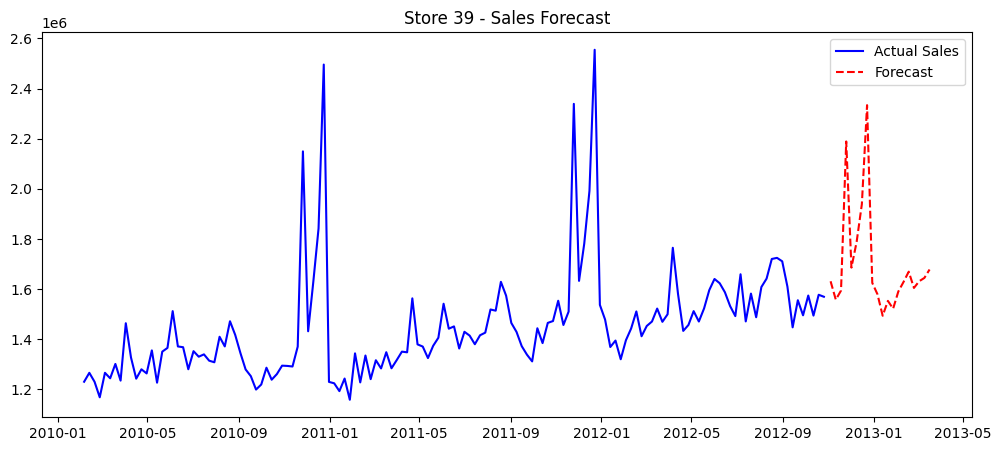

            Weekly_Sales
Date                    
2010-02-05    1001943.80
2010-02-12     955338.29
2010-02-19     916289.20
2010-02-26     863917.41
2010-03-05     990152.28
6 1 5


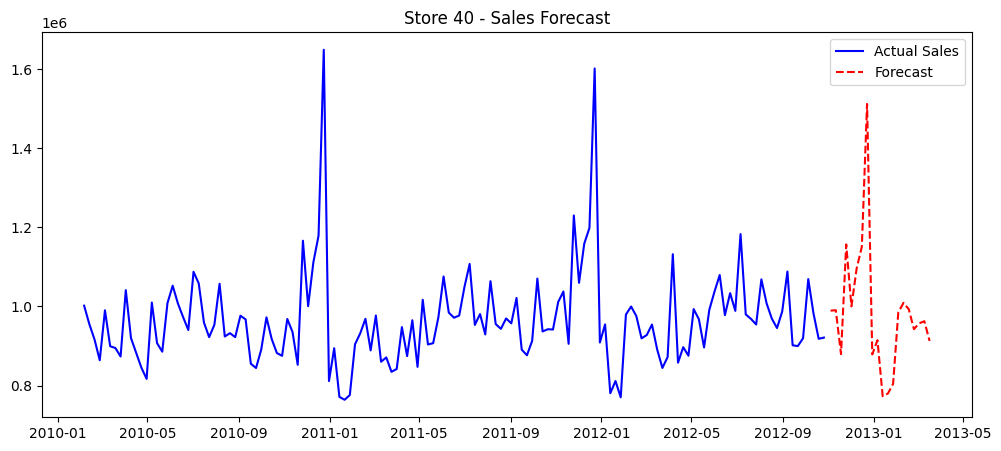

            Weekly_Sales
Date                    
2010-02-05    1086533.18
2010-02-12    1075656.34
2010-02-19    1052034.74
2010-02-26     991941.73
2010-03-05    1063557.49
4 1 0


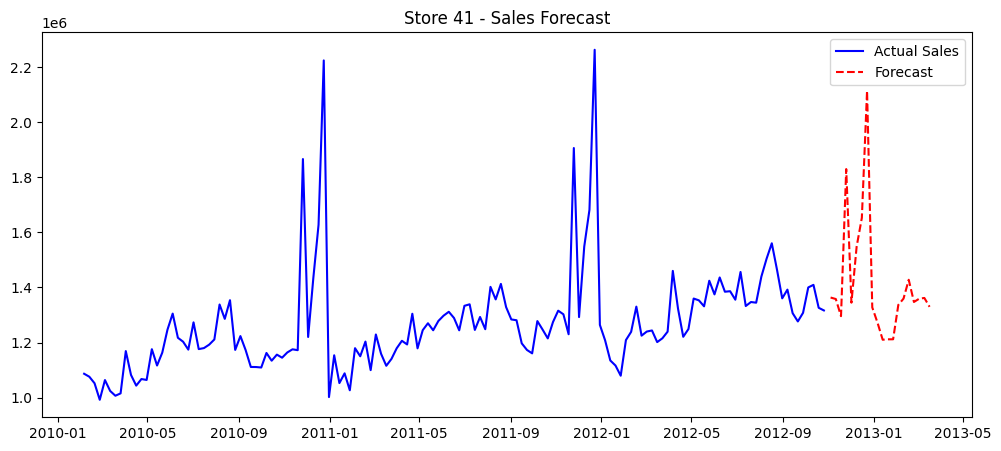

Unable to process: Store number 42
Unable to process: Store number 43
Unable to process: Store number 44
            Weekly_Sales
Date                    
2010-02-05     890689.51
2010-02-12     656988.64
2010-02-19     841264.04
2010-02-26     741891.65
2010-03-05     777951.22
0 1 7


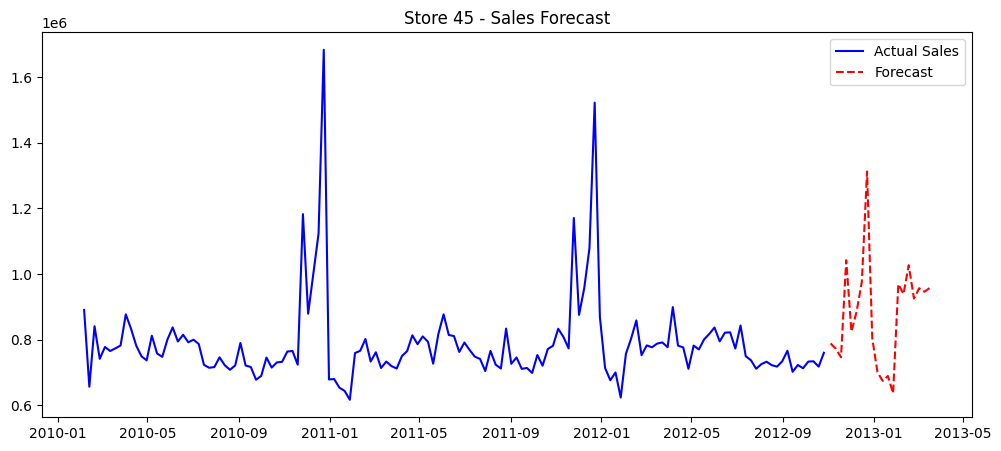

In [332]:
for i in range(1, 46):
    sales = data[data['Store'] == i][['Weekly_Sales']].dropna()  # Remove NaN values

    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        print(sales.head())
        p, d, q = min_pdq_values[i - 1]
        print(p, d, q)

        # Smaller model first
        model = SARIMAX(sales, order=(p, d, q), seasonal_order=(4, 1, 2, 52))

        # Fit with constraints
        result = model.fit(disp=0, maxiter=200, method='lbfgs')

        # Forecasting
        future_dates = pd.date_range(start=sales.index[-1], periods=21, freq='W')[1:]
        forecast_values = result.forecast(steps=20)

        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(sales.index, sales['Weekly_Sales'], label='Actual Sales', color='blue')
        plt.plot(future_dates, forecast_values, label='Forecast', color='red', linestyle='dashed')

        plt.title(f'Store {i} - Sales Forecast')
        plt.legend()
        plt.show()

    else:
        print("Unable to process: Store number", i)

In [340]:
model_fit = model.fit()

In [342]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1916.347
Date:                Mon, 10 Mar 2025   AIC                           3836.694
Time:                        22:27:46   BIC                           3842.605
Sample:                    02-05-2010   HQIC                          3839.096
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2410      0.032     -7.435      0.000      -0.305      -0.177
sigma2      2.932e+10   2.52e-13   1.16e+23      0.000    2.93e+10    2.93e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.50   Jarque-Bera (JB):               222.52
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.63
Prob(H) (two-sided):                  0.26   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

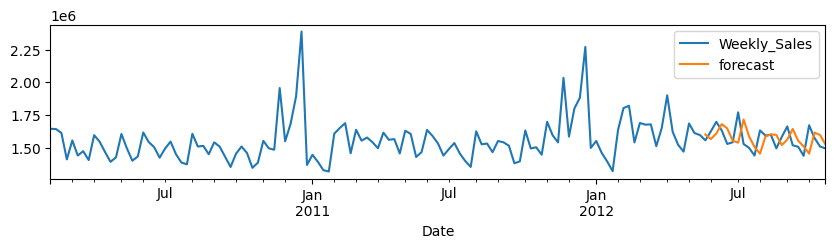

In [344]:
sales1['forecast'] = model_fit.predict(start = 120, end = 143)
sales1[['Weekly_Sales', 'forecast']].plot(figsize = (10, 2))

In [168]:
adfuller_test(sales1["Weekly_Sales"])

ADF Test-statistic : -5.102186145192286
p-value : 1.3877788330759535e-05
Lags Used : 4
Observations Used : 138


'Stationary'

In [182]:
data['Store'].nunique()

45

In [192]:
for i in range(1, 46):
    sales = data[data['Store'] == i][['Weekly_Sales']]
    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        model = ARIMA
    else:
        print("Unable to process : Store number ", i)

Unable to process : Store number  14
Unable to process : Store number  30
Unable to process : Store number  36
Unable to process : Store number  38
Unable to process : Store number  42
Unable to process : Store number  43
Unable to process : Store number  44


# 